# Analysis of Bikeshares in London

Bike-sharing allows users to rent/use bicycles on a short term basis for a price/ free. Its purpose is to reduce congestion, noise, and air pollution by providing free/affordable access to bicycles for short-distance trips in urban areas. The number of users on any given day can vary greatly. Predicting the number of hourly users lets operators manage them efficiently and in a cost-effective manner.

**Project Goal**
Use/ optimize machine learning models to predict the number of ride-sharing bikes that will be used in any given 1 hour time-period, using available information about that time/day.

**Data-set**
The dataset for this project is from [University of California Irvine’s Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset#). It contains information from a 2-year historical log corresponding to the years 2011 and 2012 from Capital Bikeshare system, Washington D.C. The data is aggregated on an hourly and daily basis. The dataset contains 17,379 records (of hours) over 731 days with 16 features (information categories) for each hour.

**Features**
* instant : Record index
* dteday: Date
* Season (1:spring, 2:summer, 3:fall, 4:winter)
* Year (0: 2011, 1:2012)
* Month (1 to 12)
* Hour (0 to 23)
* Holiday : whether that day is holiday or not
* Weekday : day of the week
* workingday: Working-day : if day is neither weekend nor holiday, value is 1, otherwise 0
* weathersit: Weather situation
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp : Normalized temperature in Celsius.
    - The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
    - Values are divided to 41 (max)
* atemp: Normalized feeling temperature in Celsius.
    - The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
    - Values are divided to 50 (max)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered

In [1]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import pandas as pd
import numpy as np
import missingno as msno
from string import punctuation as punct
import datetime as dt
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import re

Load dataset.

In [2]:
bikeshare = pd.read_csv('Bike-Sharing-Dataset/hour.csv')
bikeshare.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
bikeshare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


### Data Cleaning
We'll update the datatype for the dteday column.

In [4]:
bikeshare['dteday'] = pd.to_datetime(bikeshare['dteday'])
bikeshare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

### Exploratory Data Analysis
We'll do some statistical and correlation analysis, including:
* Correlation Table & Plot - Heatmap
* User type spead - Bar chart
* Temperature vs Usage - Scatter plot & Histogram
* Adjusted (Feeling) Temperature vs Usage - Scatter plot & Histogram
* Humidity vs Usage - Scatter plot & Histogram
* Weather Situation vs Usage - Scatter plot & Histogram
* Windspeed vs Usage - Scatter plot & Histogram
* Timeseries of Usage over time - Line chart
* Hour vs Usage - Scatter plot
* Month vs Usage - Bar chart
* Usage per Year - Bar chart
* Usage vs Weekday - Boxplot
* Casual vs Registered Users - Line Chart

We will segment plots by holiday, working day, weather situation, type of user (determined by which user count is higher)

In [5]:
bikeshare.iloc[:,1:].describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [6]:
bikeshare.iloc[:,1:].corr()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
season,1.000000,-0.010742,0.830386,-0.006117,-0.009585,-0.002335,0.013743,-0.014524,0.312025,0.319380,0.150625,-0.149773,0.120206,0.174226,0.178056
yr,-0.010742,1.000000,-0.010473,-0.003867,0.006692,-0.004485,-0.002196,-0.019157,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684,0.250495
mnth,0.830386,-0.010473,1.000000,-0.005772,0.018430,0.010400,-0.003477,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
hr,-0.006117,-0.003867,-0.005772,1.000000,0.000479,-0.003498,0.002285,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
holiday,-0.009585,0.006692,0.018430,0.000479,1.000000,-0.102088,-0.252471,-0.017036,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345,-0.030927
weekday,-0.002335,-0.004485,0.010400,-0.003498,-0.102088,1.000000,0.035955,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.026900
workingday,0.013743,-0.002196,-0.003477,0.002285,-0.252471,0.035955,1.000000,0.044672,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326,0.030284
weathersit,-0.014524,-0.019157,0.005400,-0.020203,-0.017036,0.003311,0.044672,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426
temp,0.312025,0.040913,0.201691,0.137603,-0.027340,-0.001795,0.055390,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772
atemp,0.319380,0.039222,0.208096,0.133750,-0.030973,-0.008821,0.054667,-0.105563,0.987672,1.000000,-0.051918,-0.062336,0.454080,0.332559,0.400929


Let's visualize this table to view the correlations clearly.

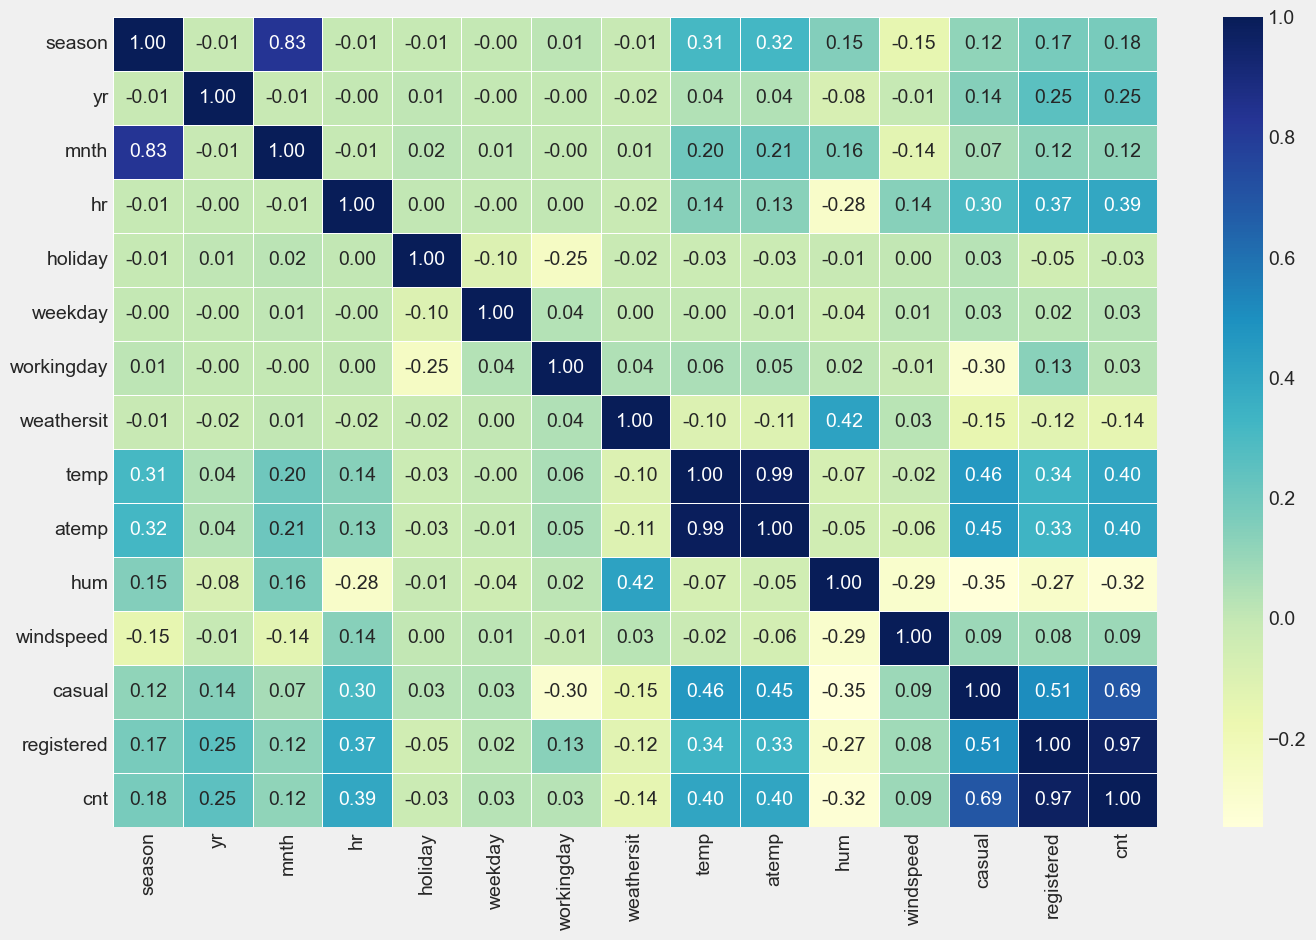

In [8]:
plt.figure(figsize=(15, 10))
sns.heatmap(bikeshare.iloc[:,1:].corr(),
            annot=True,
            linewidths=0.5,
            fmt= ".2f",
            cmap="YlGnBu");

There are some correlations with usage, which we'll analyze further:
1. humidity
2. temperature & adjusted temperature
3. hour

From the chart, it seems there's no correlation between usage and season, month, holiday, weekday, working day, weather situation and windspeed. We'll explore further.

* Correlation Table & Plot - Heatmap DONE
* User type spead - Bar chart
* Temperature vs Usage - Scatter plot & Histogram
* Adjusted (Feeling) Temperature vs Usage - Scatter plot & Histogram
* Humidity vs Usage - Scatter plot & Histogram
* Weather Situation vs Usage - Scatter plot & Histogram
* Windspeed vs Usage - Scatter plot & Histogram
* Timeseries of Usage over time - Line chart
* Hour vs Usage - Scatter plot
* Month vs Usage - Bar chart
* Usage per Year - Bar chart
* Usage vs Weekday - Boxplot
* Casual vs Registered Users - Line Chart

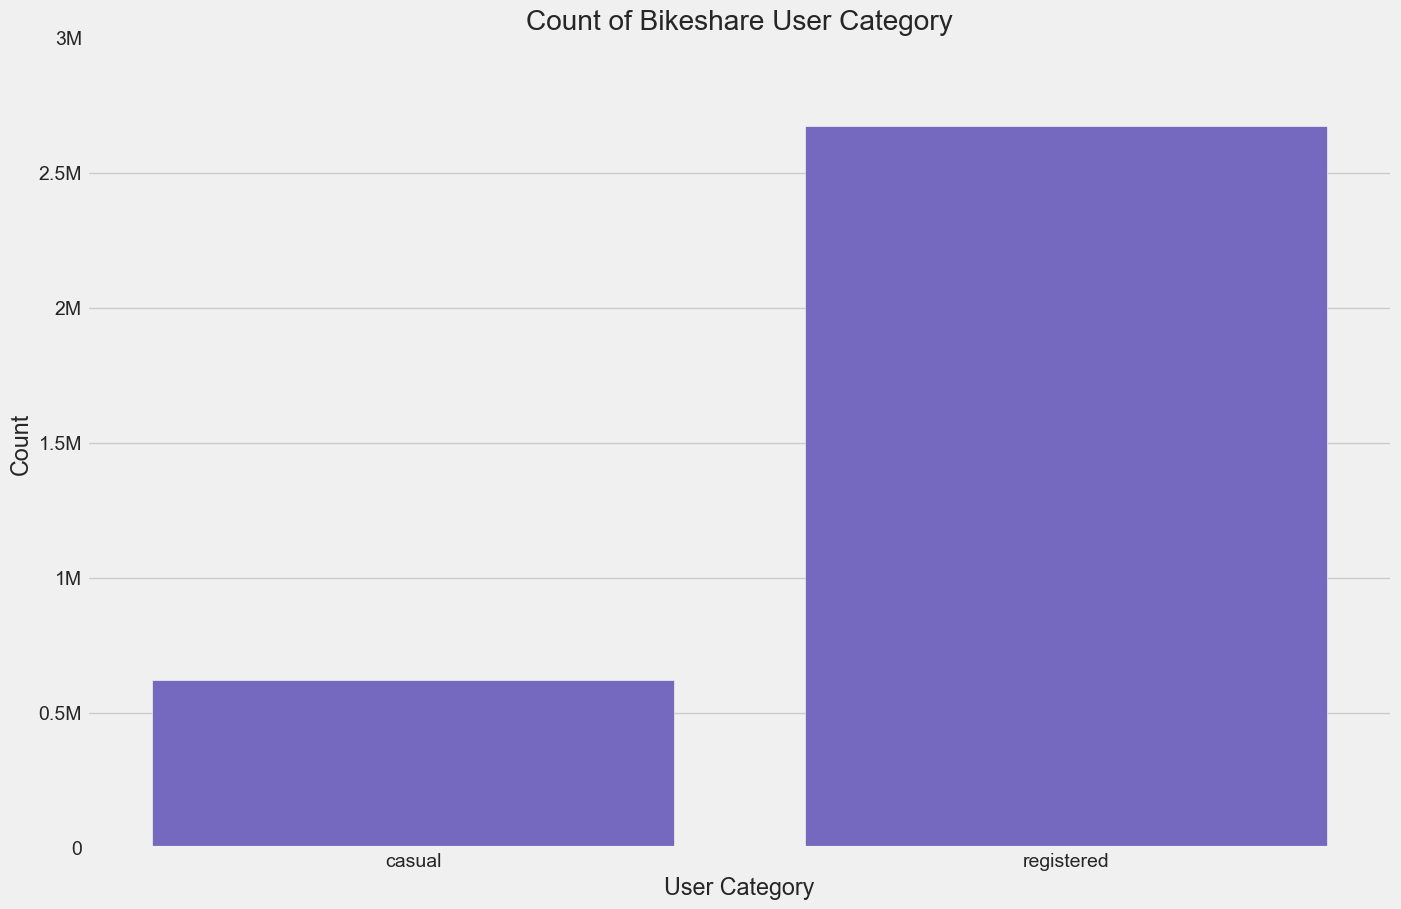

In [17]:
users = ['casual', 'registered']

fig = plt.figure(figsize = (15,10))
sns.barplot(x=users,
            y=[bikeshare['casual'].sum(),
               bikeshare['registered'].sum()],
            color='slateblue')
locs, labels = plt.yticks()
labels = ['0', '0.5M', '1M', '1.5M', '2M', '2.5M', '3M']
plt.yticks(ticks=locs, labels=labels)
plt.xlabel("User Category")
plt.ylabel("Count")
plt.title("Count of Bikeshare User Category")
plt.show()

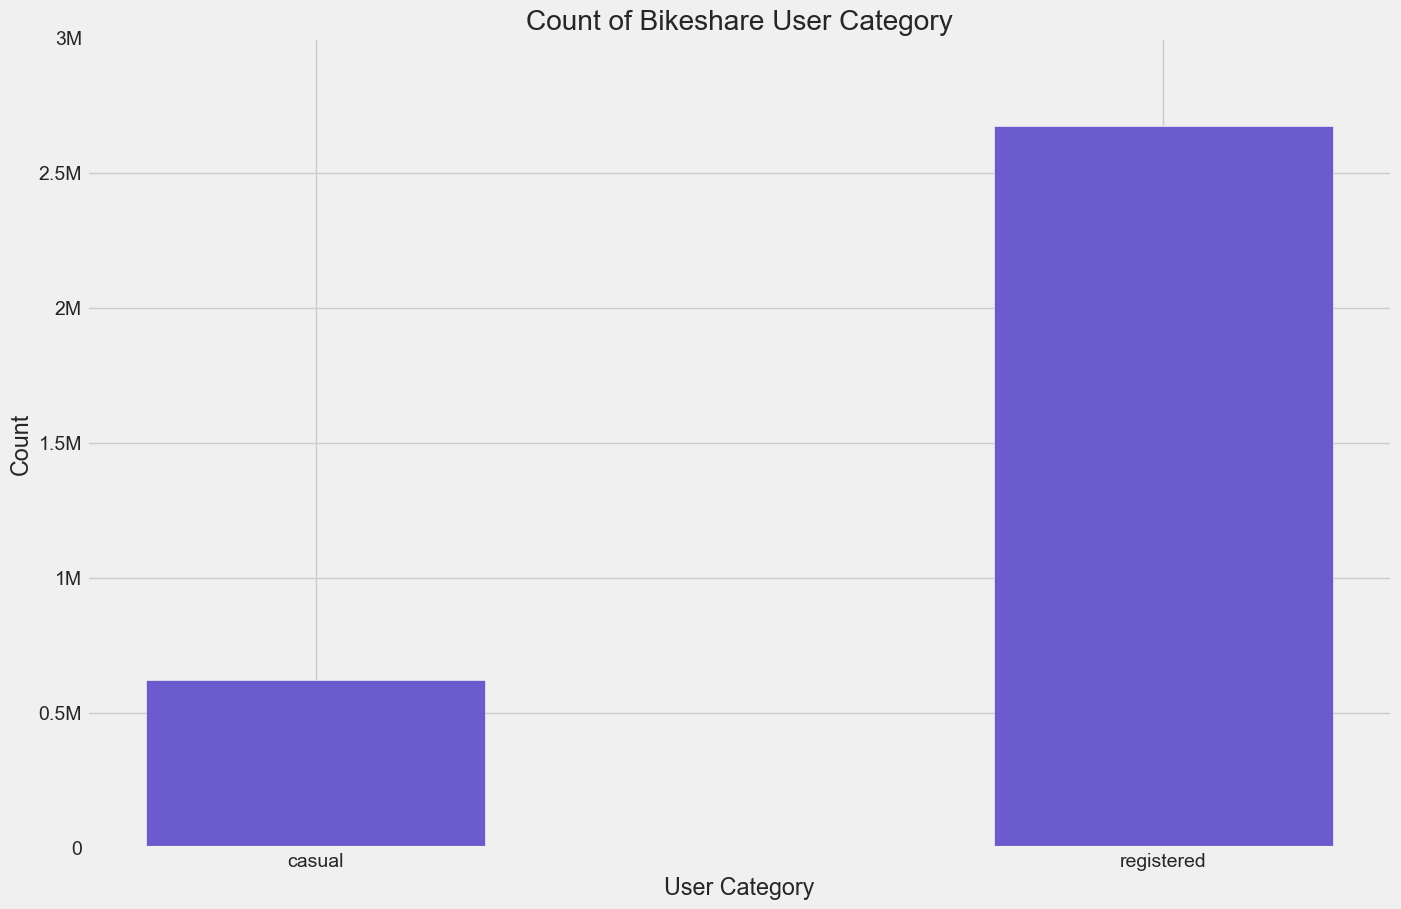

In [19]:
users = ['casual', 'registered']

fig = plt.figure(figsize = (15,10))
plt.bar(x=users,
        height=[bikeshare['casual'].sum(),
                bikeshare['registered'].sum()],
        color ='slateblue', width = 0.4)
plt.xlabel("User Category")
plt.ylabel("Count")
locs, labels = plt.yticks()
labels = ['0', '0.5M', '1M', '1.5M', '2M', '2.5M', '3M']
plt.yticks(ticks=locs, labels=labels)
plt.title("Count of Bikeshare User Category")
plt.show()

In [20]:
bikeshare.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [38]:
avg_registered = bikeshare.groupby(by=[bikeshare.dteday.dt.month]).agg({'registered':np.mean})

avg_casual = bikeshare.groupby(by=[bikeshare.dteday.dt.month]).agg({'casual':np.mean})

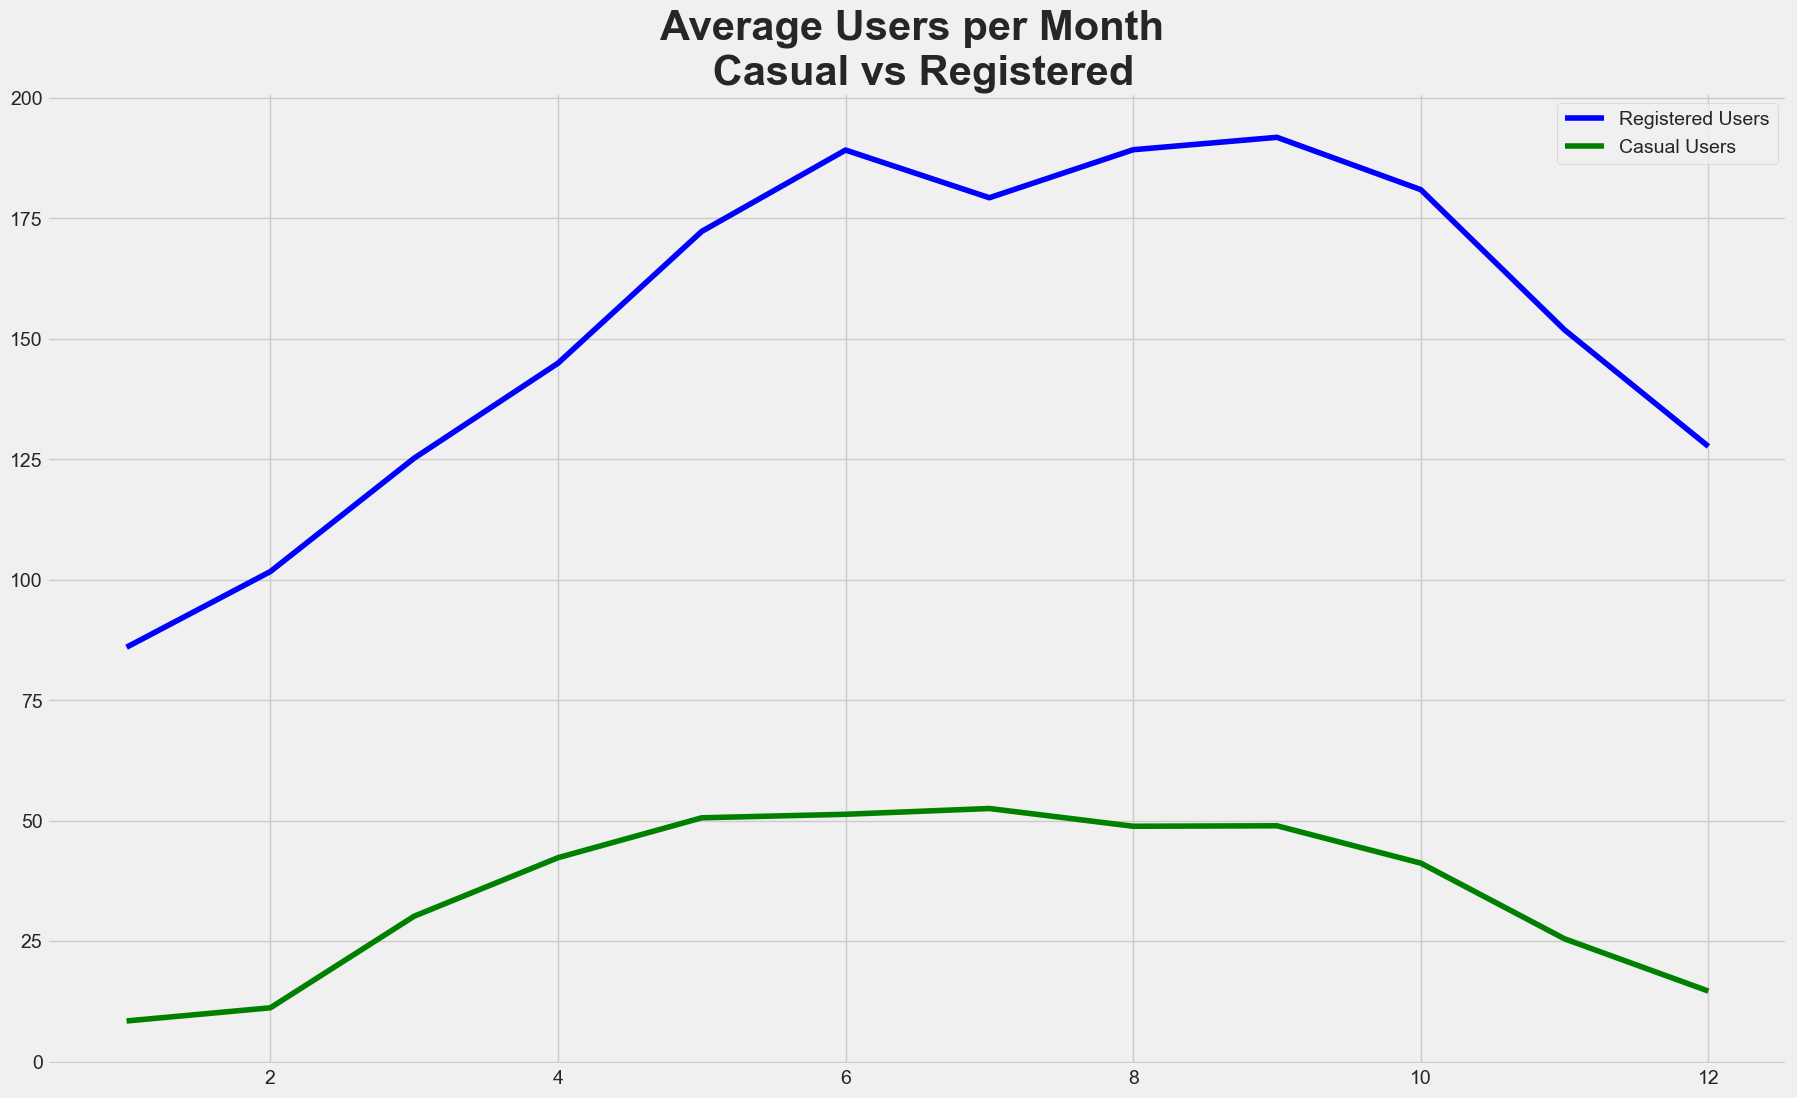

In [42]:
plt.figure(figsize=(20,12))

plt.plot(avg_registered, color='blue',
         label='Registered Users')
plt.plot(avg_casual, color='green',
         label='Casual Users')
plt.legend()
plt.title('Average Users per Month \n Casual vs Registered', weight='bold', size=30)
plt.show()

../../compiler/lib/


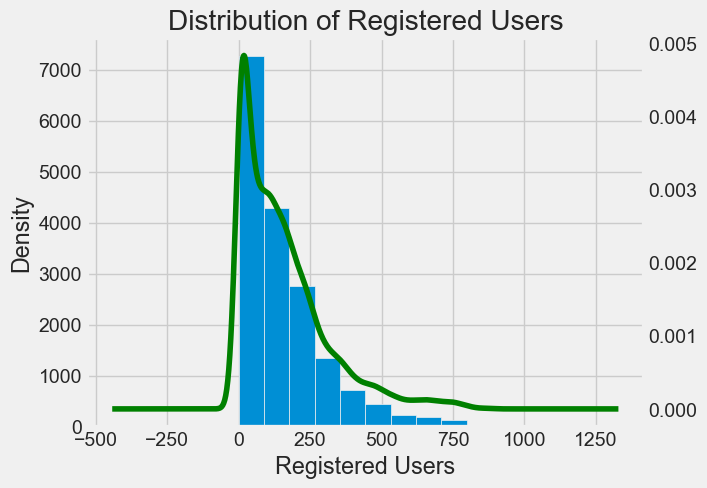

In [45]:
ax = bikeshare['registered'].plot.hist()
bikeshare['registered'].plot(kind='kde', ax=ax,
                             secondary_y=True, color='green')
ax.set_xlabel('Registered Users')
plt.title('Distribution of Registered Users')
plt.show()

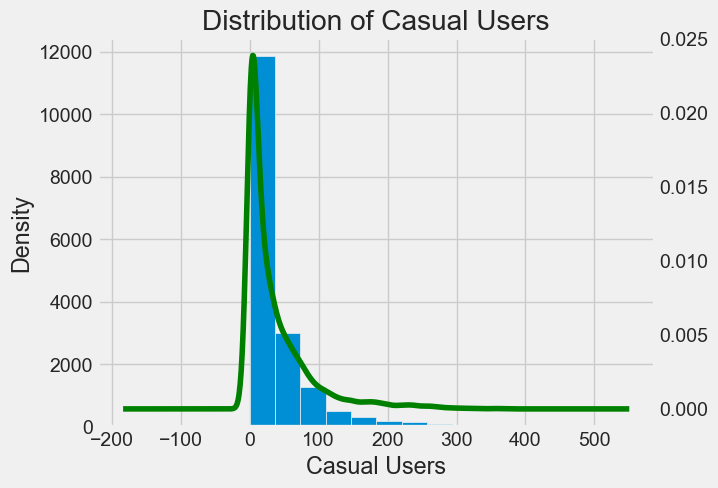

In [46]:
ax = bikeshare['casual'].plot.hist()
bikeshare['casual'].plot(kind='kde', ax=ax,
                             secondary_y=True, color='green')
ax.set_xlabel('Casual Users')
plt.title('Distribution of Casual Users')
plt.show()